**It doesn't show who works more/better, it's just some Jira stats**

In [178]:
#Disable ssl warnings
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# jira dataset and credentials
from getpass import getpass
from jira import JIRA

# data analysis and wrangling
import numpy as np
import pandas as pd
from pandas import DataFrame

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.pyplot as plt
 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [179]:
# Retrieve jira credentials
df = pd.read_csv('jiracreds.csv')

jira = JIRA(options={'server': df['server'][0], 'verify': False}, basic_auth=(df['login'][0], df['pass'][0]))
df['server'][0]

'https://jira.wiley.com/'

In [180]:
# Get isse transitions from jira server
def read_data_sets(jql, max_results=10000, status_alias=None):
    if status_alias is None:
        status_alias = {}

    issues = jira.search_issues(jql, maxResults=max_results, expand='changelog')
    rows = []
    for issue in issues:
        # Add the issue creation as the fist event transition           
        try:
            storyKey = issue.raw['fields']['customfield_16525'] 
        except Exception as e:
            storyKey = 'empty'
            
        try:
            assignee = issue.raw['fields']['assignee']['name']
        except Exception as e:
            assignee = 'none'
        
        # Other transitions (Eg: Backlog to Development)
        for history in issue.changelog.histories:
            for item in history.items:                      
                try:
                    changeAuthor = history.author.name
                except Exception as e:
                    changeAuthor = 'unknown'

                if item.field == 'status':
                    rows.append({'key': issue.key,
                                 'assignee': assignee,
                                 'storyKey': storyKey,
                                 'ts': history.created,
                                 'changeAuthor':changeAuthor,
                                 'from': status_alias.get(item.fromString) or item.fromString,
                                 'to': status_alias.get(item.toString) or item.toString})                    
    return DataFrame(rows)

In [181]:
# dirty status -> desired status
alias={
       'Closed': 'Closed',
       'In Development': 'In Development',
       'Ready for Code Review': 'Ready for Code Review',
       'In Code Review': 'In Code Review',
       'Ready for Dev Testing': 'Ready for Dev Testing',
       }
transitions = read_data_sets(jql='project=CPP2 AND updatedDate>-1w', status_alias=alias)

In [182]:
transitions.head()

,assignee,changeAuthor,from,key,storyKey,to,ts
0,none,vnabatov,Open,CPP2-1361,CPP0-590,Ready For Development,2020-03-27T05:59:27.000-0400
1,vnabatov,kchupakhin,Backlog,CPP2-1360,None,Ready For Development,2020-03-27T04:53:03.000-0400
2,vnabatov,kchupakhin,Ready For Development,CPP2-1360,None,In Development,2020-03-27T06:55:28.000-0400
3,vnabatov,kchupakhin,In Development,CPP2-1360,None,Ready for Code Review,2020-03-27T11:37:10.000-0400
4,vnabatov,vnabatov,Ready for Code Review,CPP2-1360,None,In Code Review,2020-03-27T12:19:14.000-0400


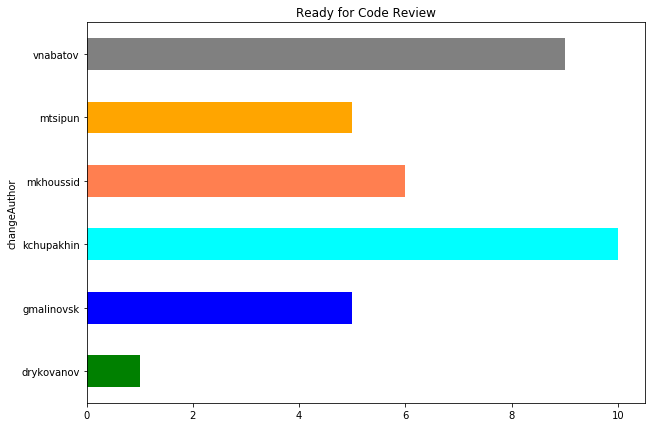

In [289]:
movedToReadyForCR = transitions[transitions.to == 'Ready for Code Review']

movedToReadyForCR[['key', 'changeAuthor','to']].groupby(['changeAuthor']).key.nunique().plot(
    x='changeAuthor', 
    y='size',
    kind='barh',
    figsize=(10, 7),
    color=tuple(["green", "blue","cyan", "coral", "orange", "gray"]),
    title='Ready for Code Review')

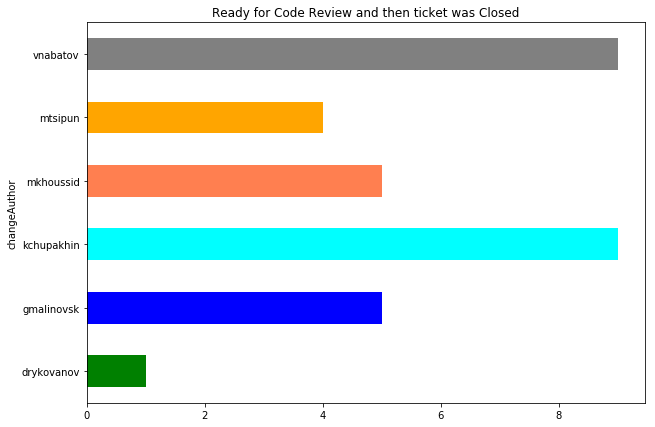

In [299]:
closed = transitions[transitions.to == 'Closed']['key'].astype(str).values.tolist()
movedToReadyForCRAndClosed = movedToReadyForCR[movedToReadyForCR.key.isin(closed)]
movedToReadyForCRAndClosed[['key', 'changeAuthor','to']].groupby(['changeAuthor']).key.nunique().plot(
    x='changeAuthor', 
    y='size',
    kind='barh',
    figsize=(10, 7),
    color=tuple(["green", "blue","cyan", "coral", "orange", "gray"]),
    title='Ready for Code Review and then ticket was Closed')


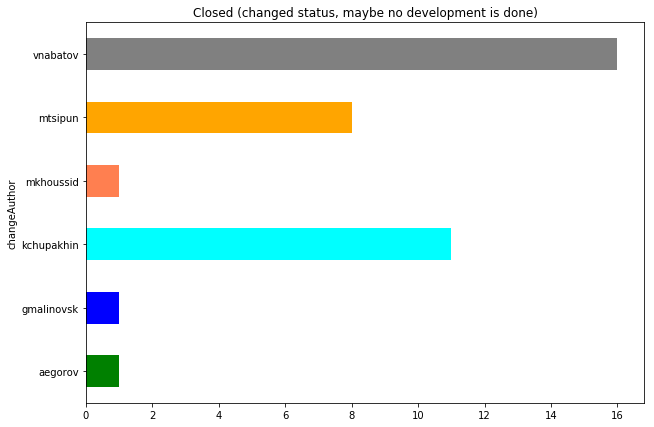

In [291]:
transitions[transitions.to == 'Closed'].groupby(['changeAuthor']).key.nunique().plot(
    x='changeAuthor', 
    y='size',
    kind='barh',
    figsize=(10, 7),
    color=tuple(["green", "blue","cyan", "coral", "orange", "gray"]),
    title='Closed (changed status, maybe no development is done)')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000000001F25AC18>],
      dtype=object)

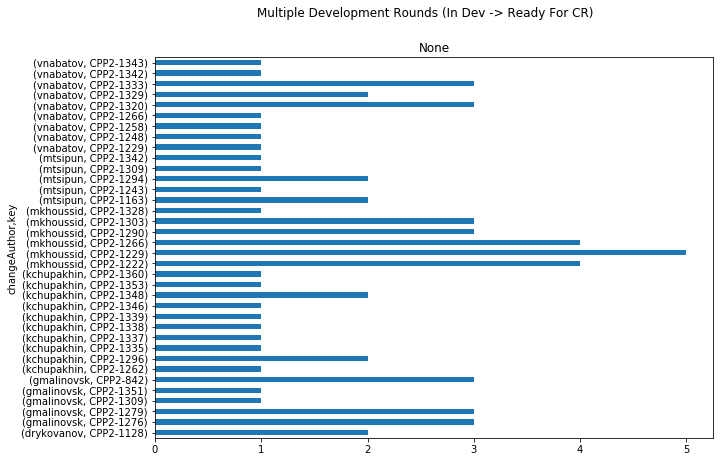

In [300]:
roundsCount = transitions[transitions.to == 'Ready for Code Review'].groupby(['changeAuthor', 'key']).size()
roundsCount.plot(
    x='changeAuthor', 
    y='size',
    kind='barh',
    subplots=True,
    figsize=(10, 7),
    title='Multiple Development Rounds (In Dev -> Ready For CR)')
